In [25]:
import csv
import polars as pl
import yfinance as yf
import pyarrow
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import pearsonr

In [26]:
class Data_Engineering():
    def __init__(self, year):
        self.year = year
        self.value_asset_data = dict()
        self.price_data = dict()
        self.amount_data = dict()

    @staticmethod
    def to_polars(dictionary):
        """
        To convert dictionaries into polars dataframe
        """
        return pl.DataFrame(dictionary) 
    
    @staticmethod
    def _concatenate_dicts(dict1, dict2):
        """
        Hidden function which concatenates two dictionaries based on common keys, values for each key are already sorted

        Args:
        - dict1 (dict): First dictionary.
        - dict2 (dict): Second dictionary.

        Returns:
        - concatenated_dict (dict): A new dictionary with concatenated lists for matching keys.
        """

        concatenated_dict = {}
        keys = set(dict1.keys()) & set(dict2.keys()) # find the intersection of keys
        for key in keys: # for each commons keys, concatenate their values
            concatenated_dict[key] = dict1[key] + dict2[key]
        return concatenated_dict

    def value_asset_data_retriever(self, asset_line_end, asset_line_start=3, to_polars=False):
        """
        Retrieve data from a file stored in the source_files folder, whose name is in the format "YYYY.csv". Lines contains monthly value for each asset in rows, calculated at the end of each month.
        
        Args:
            asset_line_end (int): what's the last line corresponding to an asset
            asset_line_start (int, default = 3): what's the first line corresponding to an asset
            to_polars (bool, default = False): convert to polar

        """
        with open('source_files/' + str(self.year) + '.csv', mode='r') as f:
            reader = csv.reader(f)
            # Skip the first 3 lines
            for _ in range(asset_line_start):
                next(reader)

            # create a dictionary whose keys are tickers and values are the list of values in dollars for each asset, for each month
            for i, values in enumerate(reader):
                if i == asset_line_end - asset_line_start:
                    break
                self.value_asset_data[values[0]] = list(map(lambda x: int(x.replace(',', '')), values[3:15]))

        if to_polars:
            self.value_asset_data = self.to_polars(self.value_asset_data)

    def price_data_retriever(self, sampling = 'ME', to_polars=False):
        """
        Retrieve closing price data from yahoo finance for each ticker, in the given year
        
        Args:
            sampling (string, default = 'ME'): what's the frequency of data? 'ME' for monthly data
            to_polars (bool, default = False): convert to polar

        """
        tickers = list(self.value_asset_data.keys())
        for ticker in tickers:
            if ticker == "INTEL":   # to be deleted
                continue            # to be deleted
            self.price_data[ticker] = yf.Ticker(ticker).history(start = str(self.year) + '-01-01', 
                                                                end=str(self.year + 1) + '-01-01')['Close']
            if sampling == 'ME':
                self.price_data[ticker] = self.price_data[ticker].resample('ME').last().tolist()
                
        if to_polars:
            self.price_data = self.to_polars(self.price_data)

    def amount_data_calculator(self, to_polars=False):
        """
        Calculate the amount of asset each month, per each ticker
        """

        for key in self.value_asset_data:
            if key == "INTEL":      # to be deleted
                continue            # to be deleted
            self.amount_data[key] = [value / price for value, price in zip(self.value_asset_data[key], self.price_data[key])]

        if to_polars:
            self.amount_data = self.to_polars(self.amount_data)

    def get_difference(self, mode, diff=1, pct_change=False):
        """
        Calculate absolute or percentuale change in price or amount of asset per each moment
        
        Args:
            mode (string): "price" or "amount", according to the data to calculate the difference of
            diff (int, default = 1): lag
            pct_change (bool, default = False): calculate the percentuale change
        
        Returns:
            pl.Dataframe (polar dataframe)
        """
        if mode == "price":
            data = self.price_data if isinstance(self.price_data, pl.DataFrame) else self.to_polars(self.price_data)
            if pct_change:
                self.price_difference_pct = data.select(pl.all().pct_change(diff))
                return self.price_difference_pct
            else:
                self.price_difference = data.select(pl.all().diff(diff))
                return self.price_difference

        elif mode == "amount":
            data = self.amount_data if isinstance(self.amount_data, pl.DataFrame) else self.to_polars(self.amount_data)
            self.difference_amount = data.select(pl.all().diff(diff))
            return self.difference_amount

    def concatenate_data(self, older):
        """
        Concatenate data from another DataEngineering instance into this one.

        Args:
        - older (InstanceClass): Another instance of DataEngineering to concatenate with.

        Returns:
        - new_instance (InstanceClass): A new instance with concatenated data.
        """
        concatenated_value_asset_data = self._concatenate_dicts(older.value_asset_data, self.value_asset_data)
        concatenated_price_data = self._concatenate_dicts(older.price_data, self.price_data)
        concatenated_amount_data = self._concatenate_dicts(older.amount_data, self.amount_data)
        
        # Create a new instance with default year and updated data
        new_instance = Data_Engineering(year = self.year)
        new_instance.value_asset_data = concatenated_value_asset_data
        new_instance.price_data = concatenated_price_data
        new_instance.amount_data = concatenated_amount_data
        return new_instance

data_2023 = Data_Engineering(2023)
data_2023.value_asset_data_retriever(13)
data_2023.price_data_retriever()
data_2023.amount_data_calculator()

data_2022 = Data_Engineering(2022)
data_2022.value_asset_data_retriever(16)
data_2022.price_data_retriever()
data_2022.amount_data_calculator()

# Concatenate data

data_2022_2023 = data_2023.concatenate_data(data_2022)

# Exploratory Data Analysis

In [27]:
value_dataframe = pd.DataFrame(data_2022_2023.value_asset_data)
plt.style.use('ggplot')

In [28]:
value_dataframe.head()

,VSS,ERUS,VBR,VYM,VYMI,VT,SONY,VTV,INTEL,CHEK
0,50476,0,68384,50184,219808,174267,11166,142765,24410,9234
1,49492,0,69496,49446,215392,169439,10253,142925,23850,9882
2,49556,8060,70376,50513,216384,172193,10271,144890,24780,7800
3,45884,8060,65916,48389,204320,163373,8605,140700,21795,7200
4,46248,8060,67144,50090,208000,164180,9407,144090,22210,7200


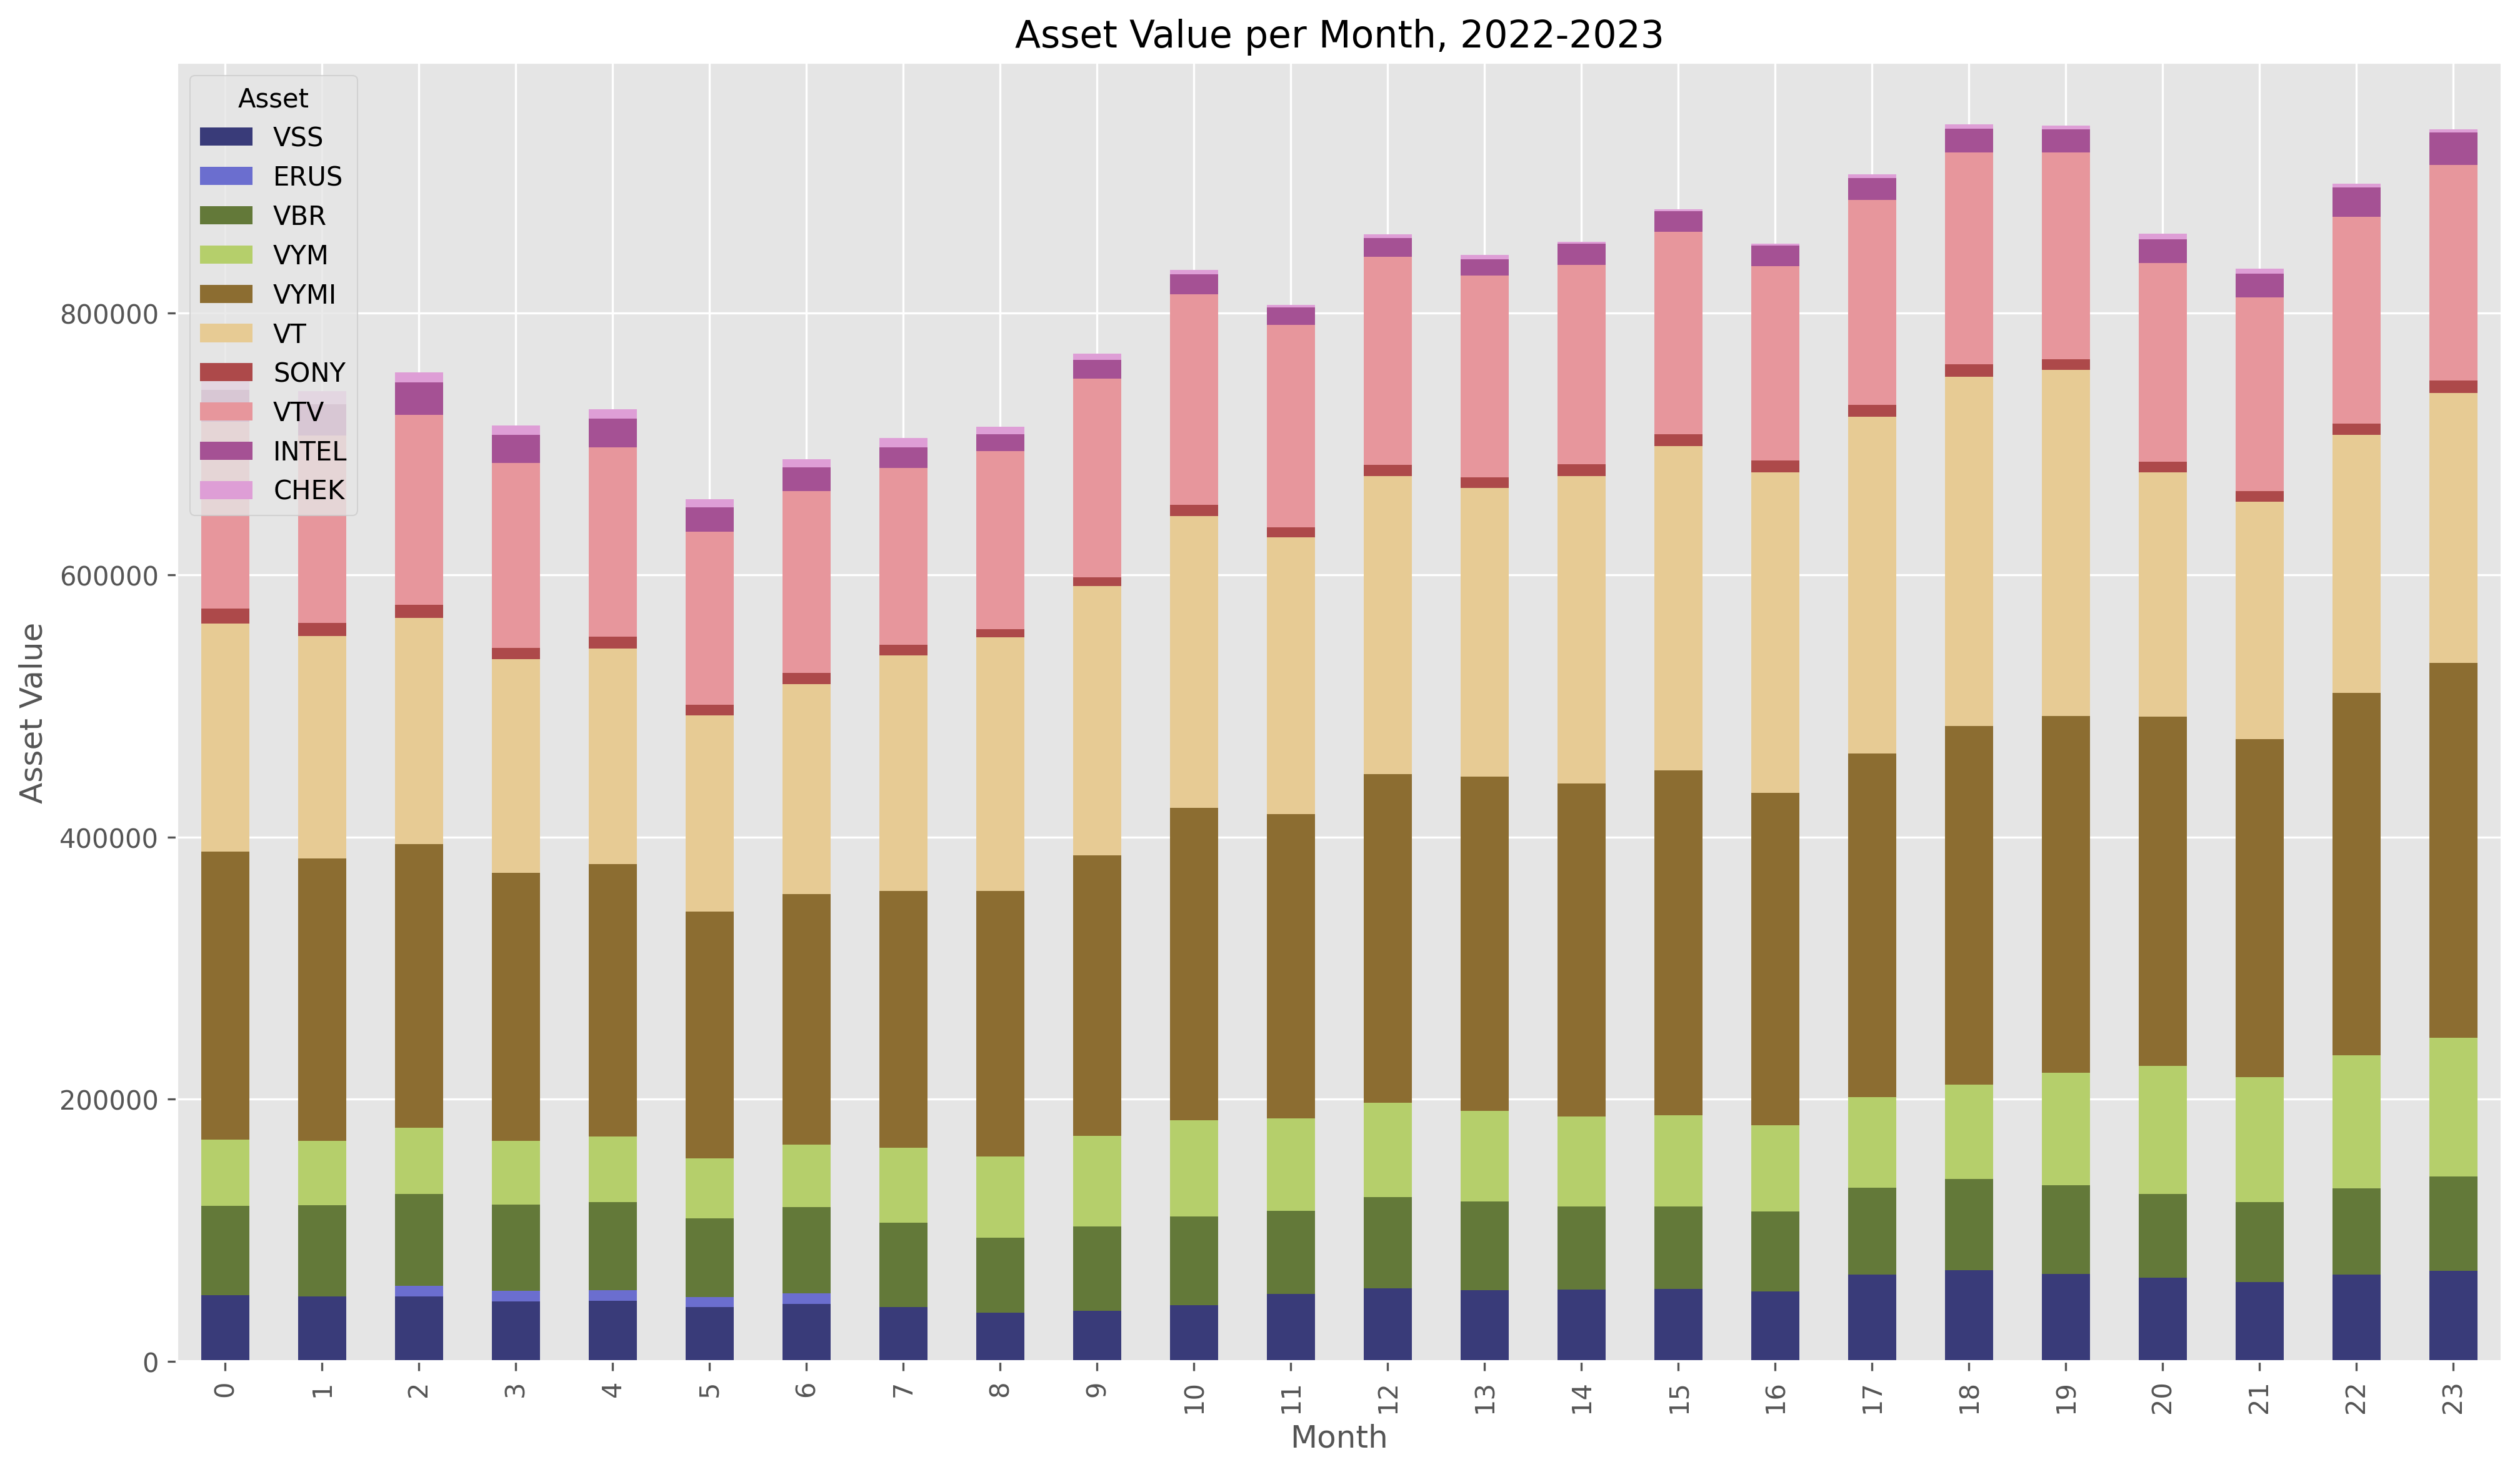

In [29]:
value_dataframe.plot(kind = 'bar', stacked = True, colormap = 'tab20b', figsize=(16,9))
plt.gcf().set_dpi(300)
plt.xlabel('Month')
plt.ylabel('Asset Value')
plt.title('Asset Value per Month, 2022-2023')
plt.legend(title='Asset', loc='upper left')
plt.show()

In [30]:
amount_data, price_data = data_2022_2023.get_difference("amount"), data_2022_2023.get_difference("price", pct_change = True)

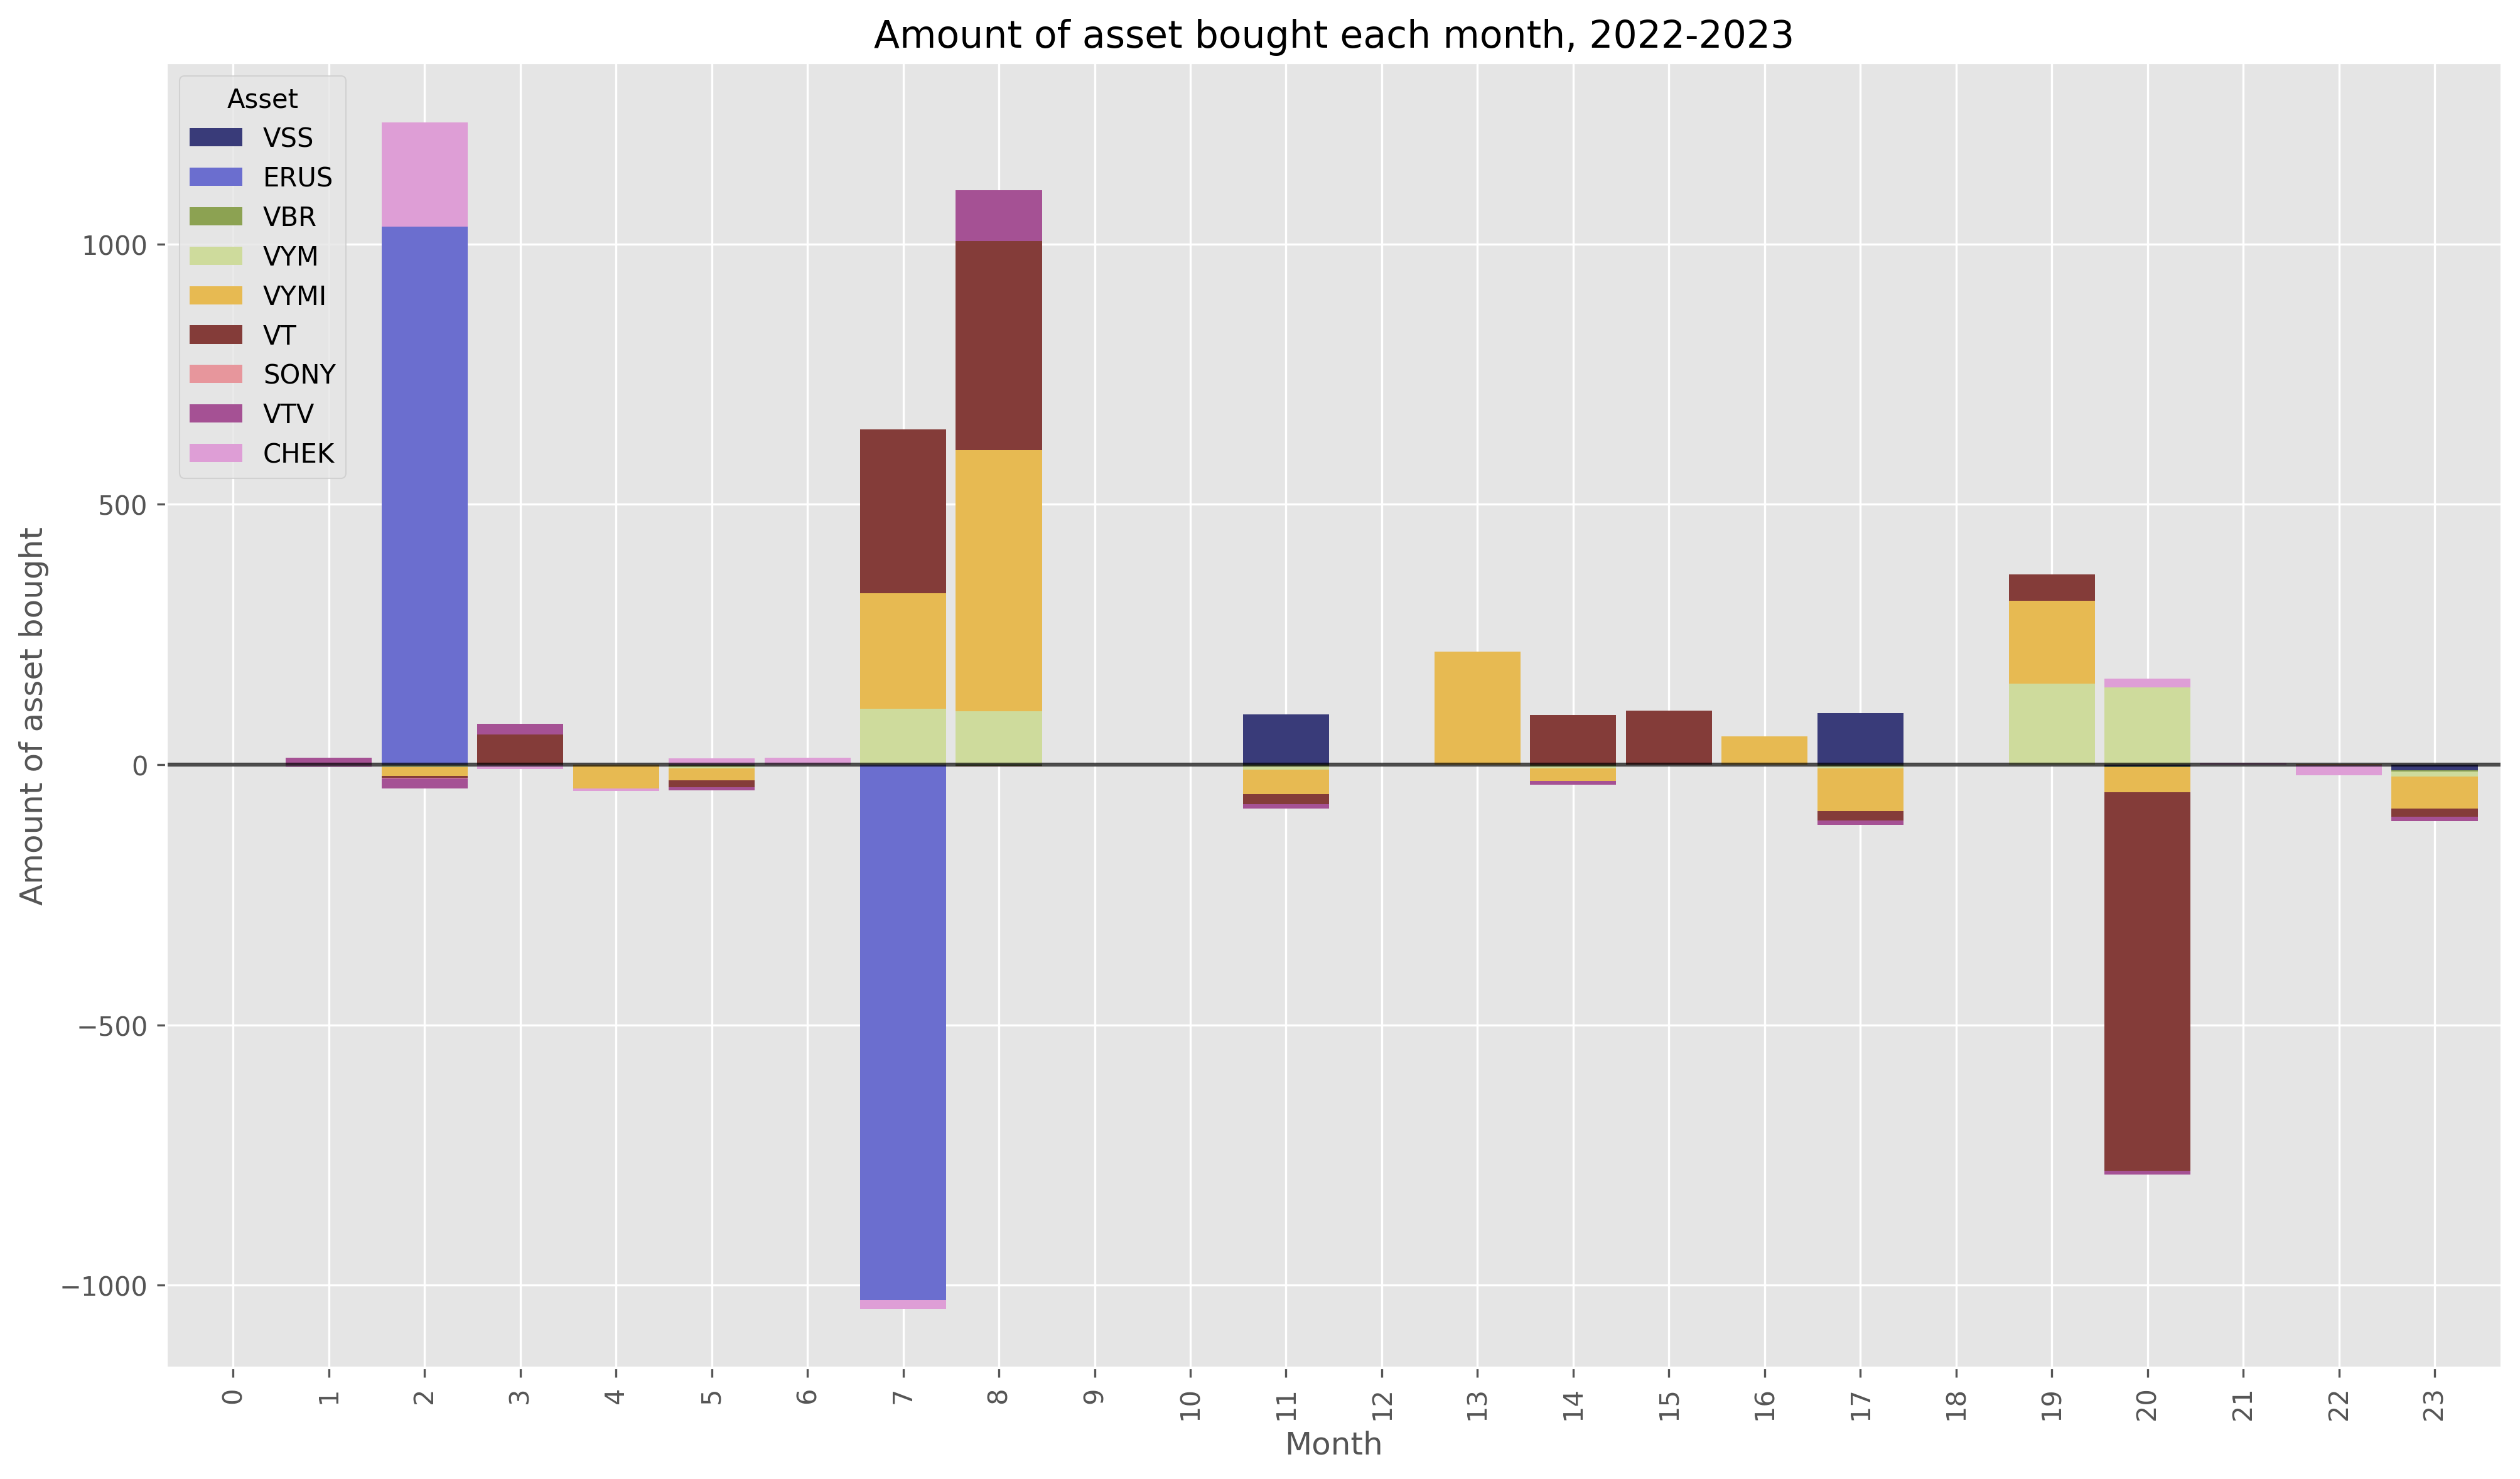

In [31]:
amount_data.to_pandas().plot(kind = 'bar', figsize = (16,9), stacked = True, width = 0.9, colormap = 'tab20b')
plt.gcf().set_dpi(300)
plt.xlabel('Month')
plt.ylabel('Amount of asset bought')
plt.title('Amount of asset bought each month, 2022-2023')
plt.legend(title='Asset', loc='upper left')
plt.axhline(y = 0, color = 'black', alpha = 0.7)
plt.show()

# Detecting statistically significant correlations in asset purchasing
Given:
* a set of asset $A_{n}$,
* their quantity bought each month $Quantity_{A, t}$,
* their monthly price $Price_{A, t}$

For each asset $A$ is calculated the pearson correlation between its Quantity and Quantities and Prices of any other asset, at different time lags, as well.
The variables significantly correlated will be returned, and their correlation coefficients.

In [32]:
class Correlation:
    """The correlation class provide a series of attributes to manipulate data and get significant correlation coefficients between current and/or past prices and the amount of asset bought at any given time"""
    def __init__(self, list_of_dataframes):
        """
        Args:
            list_of_dataframes (list): a list containg different dataframes, whose columns will be the variables among which the correlation coefficients will be calculated
        """
        self.list_of_dataframes = list_of_dataframes

    def add_shifting(self, list_of_dataframe_index_to_apply_shifting, list_of_lags, add = False):
        """
        Method to add lags - shifting the row up or down by n lags -, and eventually appending the shifted dataframe or substituiting it
        Args: 
            list_of_dataframe_index_to_apply_shifting (list) : a list contaings int, corresponding to the indexes of dataframe you want to apply shifting in self.list_of_dataframess list
            list_of_lags (list) : a list containing positive or negative int, corresponding to the number of lags to be applied for each dataframe 
            add (bool, default = False) : if you want to substitute or append the shifted dataframe

        Example:
            INSTANCE.add_shifting([1],[1], add = True)
            will apply to the the 2nd dataframe of self.list_of_dataframse a shift of +1 and the resulting dataframe will be appended
        """
        for ix, dataframe_index in enumerate(list_of_dataframe_index_to_apply_shifting):
            lag = list_of_lags[ix]
            df = self.list_of_dataframes[dataframe_index]
            shifted_df = df.shift(lag)  

            # Renaming the column according to the lag applied
            new_column_names = {col: f"{col}_{lag}" for col in df.columns}

            shifted_df = shifted_df.rename(new_column_names)

            # Replace the DataFrame in the list or append it if 'add' is True
            if add:
                self.list_of_dataframes.append(shifted_df)
            else:
                self.list_of_dataframes[dataframe_index] = shifted_df

    def combine_dataframes(self, shared_names=False, list_of_suffix=None):
        """
        Method to combine dataframes. In case dataframes have the same name, prompt "True" and a list of suffix, per each dataframe, so that the first suffix will be added to all the columns in the first dataframe
        Args:
            shared_names (bool, default = False) : do the combined dataframe have at least one common column name?
            list_of_suffix (list, default = None) : if shared_names == True, provide a list of strings for suffixes, one per each dataframe yo're going to combine. An empty string can be used if only a part of the dataframes share column names
        """
        if shared_names:
            if list_of_suffix is None:
                raise ValueError("list_of_suffix must be provided when shared_names is True")
            
            # Add suffixes to each DataFrame's columns
            for index, df in enumerate(self.list_of_dataframes):
                suffix = list_of_suffix[index]
                self.list_of_dataframes[index] = df.rename(
                    {col: f"{col}{suffix}" for col in df.columns}
                )
        
        self.combined_dataframes = pl.concat(self.list_of_dataframes, how="horizontal").drop_nulls()

    def calculate_correlation(self):
        """
        Calculate correlations among each pair of columns and display only the significant ones
        """

        columns = self.combined_dataframes.columns
        
        self.correlations = {}
        
        for column_a in columns:
            for column_b in columns:
                # Don't calculate correlation of a column with itself and skip the calculations with prices
                if column_a == column_b or column_a.endswith("p"):
                    continue
                else:
                    corr, p_value = pearsonr(self.combined_dataframes[column_a], self.combined_dataframes[column_b])
                    if p_value <= 0.05:
                        if f"{column_b} vs. {column_a}" not in self.correlations:
                            self.correlations[f"{column_a} vs. {column_b}"] = float(corr)
    
correlation = Correlation([amount_data, price_data])
correlation.add_shifting([1],[1], add = True)
correlation.combine_dataframes(shared_names=True, list_of_suffix=['a','p','p'])
correlation.calculate_correlation()
correlation.correlations

{'VSSa vs. VBRa': -0.45470140966704875,
 'VSSa vs. SONY_1p': 0.4392785256088362,
 'ERUSa vs. CHEKa': 0.7699652302879617,
 'ERUSa vs. ERUSp': -0.7304249725224832,
 'ERUSa vs. ERUS_1p': -0.517799765720447,
 'VBRa vs. SONYa': 0.5343175228162523,
 'VYMa vs. VYMIa': 0.5260745841709428,
 'VYMa vs. VSSp': -0.4249926249581052,
 'VYMa vs. VTp': -0.43822760251634274,
 'VYMIa vs. VTa': 0.5653913973718824,
 'VYMIa vs. VTVa': 0.7974112675842748,
 'VYMIa vs. VSSp': -0.4786128111958371,
 'VYMIa vs. VYMp': -0.4695072592800599,
 'VYMIa vs. VYMIp': -0.5122932461011658,
 'VYMIa vs. VTp': -0.4799861792001504,
 'VYMIa vs. SONYp': -0.499256183797603,
 'VYMIa vs. VTVp': -0.4714101485293682,
 'VTa vs. VTVa': 0.48579968699815296,
 'VTVa vs. VTp': -0.42530554171903057,
 'VTVa vs. SONYp': -0.43924925313667246,
 'CHEKa vs. ERUSp': -0.9833487784393877,
 'CHEKa vs. ERUS_1p': -0.6386381246518602}

# Detecting purchasing strategy: focusing on the amount each month using a time-series approach
Given:
* a set of asset $A_{n}$,
* their quantity bought each month $Quantity_{A, t}$,

For each asset $A$, using time-series analysis, discovering any statistically significant association between $Quantity_{A, t}$ at any given time and $Quantity_{A, t-n}$

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

<Axes: >

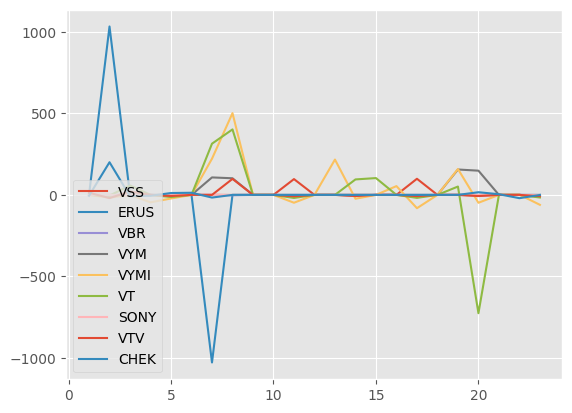

In [34]:
amount_data = amount_data.to_pandas().dropna()
amount_data.plot()

In [35]:
def adf_test(dataframe):
    """
        Calculating stationarity on each dataframe column using KPSS and ADF tests.
        Args:
            dataframe (pandas.Dataframe) : dataframe whose columns are time series and stationarity should be calculated
        """
    for column in dataframe.columns:
        adf_test = adfuller(dataframe[column], autolag="AIC")
        kpss_test = kpss(dataframe[column], regression="c", nlags="auto")
        print("Stationarity check for", column)
        if adf_test[1] < 0.05:
            print("The series is stationary based on ADF test")
        else: 
            print("The series is not stationary based on ADF test")
        if float(kpss_test[1]) < 0.05:
            print("The series is not stationary based on KPSS test")
        else:
            print("The series is stationary based on KPSS test\n")
    
adf_test(amount_data)

Stationarity check for VSS
The series is not stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for ERUS
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VBR
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VYM
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VYMI
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VT
The series is stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for SONY
The series is not stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for VTV
The series is not stationary based on ADF test
The series is stationary based on KPSS test

Stationarity check for CHEK
The series is stationary based on ADF 

/home/vincenzopi/Scrivania/MrRipStrategyAnalysis_venv/MrRipStrategyAnalysis_venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


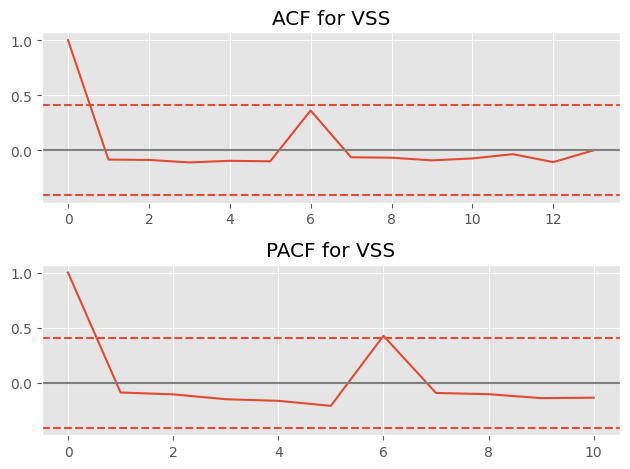

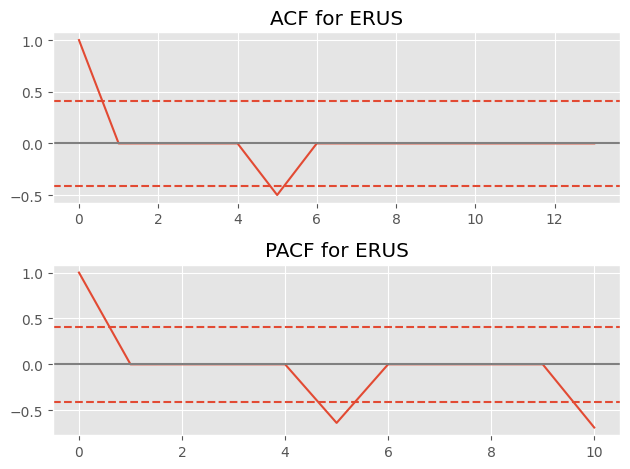

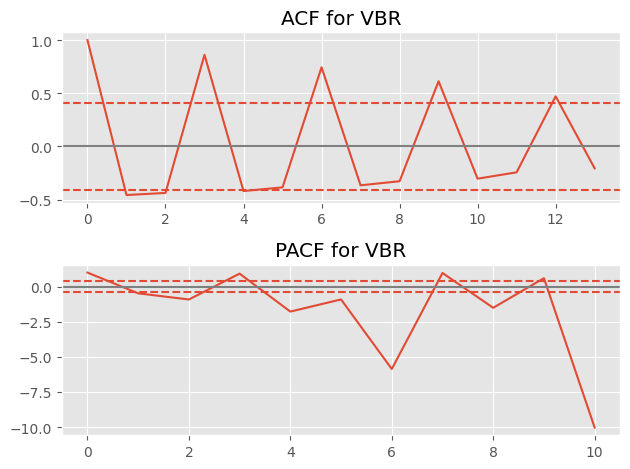

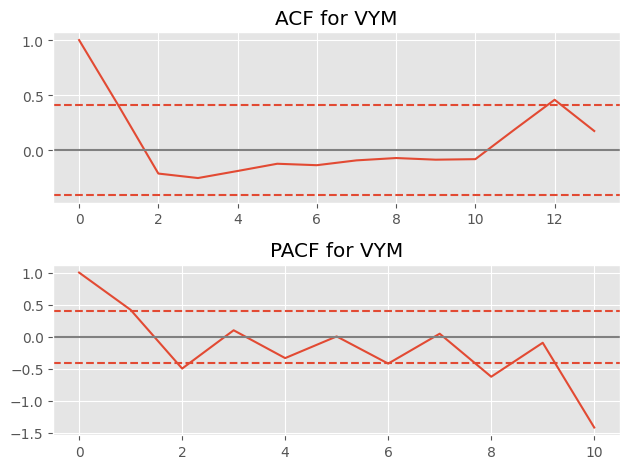

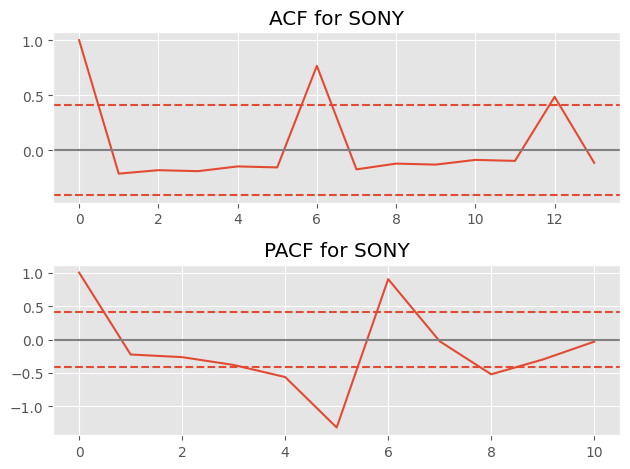

In [36]:
def plotting(function):
    plt.plot(function)
    plt.axhline(0, color='grey')
    plt.axhline(confidence_interval, linestyle='dashed')
    plt.axhline(-confidence_interval, linestyle='dashed')

for column in amount_data.columns:
    acf_values = acf(amount_data[column])
    pacf_values = pacf(amount_data[column])

    confidence_interval = 1.96 / np.sqrt(len(amount_data[column]))
    
    if any(np.abs(acf_values[1:]) > confidence_interval) or any(np.abs(pacf_values[1:]) > confidence_interval):
        
        plt.subplot(211)
        plotting(acf_values)
        plt.title(f"ACF for {column}")

        plt.subplot(212)
        plotting(pacf_values)
        plt.title(f"PACF for {column}")

        plt.tight_layout()
        plt.show()